# Nprofiles

This notebook contains an example workflow for analyzing JMENano .root files using ROOTs RDataFrames. Basic usage such as defining and redefining of columns is demonstrated and defining and using custom functions from libraries is also included. Small examples on how to use ROOTs C++ datatypes from Python are also shown.

## Libraries and macros

To load Python packages and use them with pyROOT standard `import` statements are used. If you're using a collection of macros defined in a `.C` file, you'll need to open ROOT in the same directory as the `.C` file and use

    .L NHelpers.C++

This will create a `.so` file that you can load to the notebook using `ROOT.gSystem.Load()`. An alternative, and performance wise slightly slower, approach is to use the `ROOT.gROOT.LoadMacro()` function with the `.C` file to load the macros. Latter approach doesn't require compilation, so it might be preferrable when still developing the library. An example of both approaches is shown below.

In [1]:
import ROOT
import numpy as np
import fnmatch
from os import listdir

ROOT.gStyle.SetPalette(ROOT.kGreyYellow) # LightTemperature


Welcome to JupyROOT 6.27/01


In [2]:
RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame
RunGraphs = ROOT.RDF.Experimental.Distributed.RunGraphs
initialize = ROOT.RDF.Experimental.Distributed.initialize

## Data

This part of the notebook goes over how to load a larger dataset into a RDataFrame and then how to modify the data and create new data based on the previous.

###  Reading

Data is usually given in multiple files, since the complete dataset might be very large. For this reason ROOT's `TChain` datatype is favourable, as it essentially creates a list of files that can then be passed to the `RDataFrame` constructor. Usage of `TChain` is simple, when constructing it the name of the tree is passed, after which the files are added by calling `.Add(filename)` as shown below.

Another thing to utilize is the range of the loop. For testing purposes you might not want to load or analyze the complete dataset, but instead a smaller fraction. The number of files included in the `RDataFrame` can be changed by looping over a smaller set of files.

In [3]:
# Simulation data
# This line finds all files in the directory that end with .root
files = list(fnmatch.filter(listdir("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000"), "*.root"))

# Load the files and create the RDataFrame
chain = ROOT.TChain("Events")
for file in files[0:10]:
    chain.Add("root://eosuser.cern.ch//eos/user/n/ntoikka/data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)

print(f"Event count: {chain.GetEntries()}") # Some useful info / confirmation

df_MC = RDataFrame(chain, sparkcontext=sc, npartitions=64)

Event count: 6108000


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [13]:
# Real data
# This line finds all files in the directory that end with .root)
files = list(fnmatch.filter(listdir("../../data/UL2018_MiniAODv2_JMENanoAODv9-v1/230000"), "*.root"))

# Load the files and create the RDataFrame
chain = ROOT.TChain("Events")
for file in files[0:10]:
    chain.Add("root://eosuser.cern.ch//eos/user/n/ntoikka/data/UL2018_MiniAODv2_JMENanoAODv9-v1/230000/"+file)

print(f"Event count: {chain.GetEntries()}") # Some useful info / confirmation

df_DT = RDataFrame(chain, sparkcontext=sc, npartitions=64)

df_DT._headnode.backend.distribute_headers("../macros/Nhelpers.hpp")
df_DT._headnode.backend.distribute_headers("../macros/tdrstyle_mod15.hpp")

Event count: 4514762
22/06/30 14:11:46 WARN SparkContext: The path ../macros/Nhelpers.hpp has been added already. Overwriting of added paths is not supported in the current version.
22/06/30 14:11:46 WARN SparkContext: The path ../macros/tdrstyle_mod15.hpp has been added already. Overwriting of added paths is not supported in the current version.


### C/C++ variables for analysis (Veto map)

When using the `.Define()` and `.Redefine()` you can't use variables defined in Python code. A workaround is to use the `ROOT.gInterpreter.Declare()` function which allows you to define C/C++ variables or functions quickly in Python. The code shown below reads a 2D histogram from a file to a variable `vm` for further use in the analysis.

In [6]:
# f = ROOT.TFile("../../data/hotjets-UL18.root")
# vm = f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1")

read_map_code = """
TFile f("../../data/hotjets-UL18.root");
TH2D *vm = (TH2D*)f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1");
auto limits = veto_map(vm, 5);
"""

ROOT.gInterpreter.Declare(read_map_code)


True

### Filters

When filtering the data the filters are passed as strings to the filter function. The strings can be written directly to the function, or they can be defined before to make quicker changes and possibly increase readability.

Here are two examples of how to implement filter strings. The first example, `pass_filt`, is a simple string that includes boolean variables defining what flags from the dataset to use for filtering. The second example has predefined variables that can then be included in the filter string by using Pythons f-string expressions.

In [7]:
# First example
pass_filt = """
	(Flag_goodVertices) &&
	 (Flag_globalSuperTightHalo2016Filter) &&
	 (Flag_HBHENoiseFilter) &&
	 (Flag_HBHENoiseIsoFilter) &&
	 (Flag_EcalDeadCellTriggerPrimitiveFilter) &&
	 (Flag_BadPFMuonFilter) &&
	 (Flag_BadPFMuonDzFilter) &&
	 (Flag_globalTightHalo2016Filter) &&
	 (Flag_CSCTightHaloFilter) &&
	 (Flag_ecalBadCalibFilter) && 
	 (Flag_eeBadScFilter)
	""".replace("\n", "").replace("\t", "")

# Second example
pT_cut = 15.0
eta_cut = 1.3
deltaR_cut = 0.2
cut_str = f'(abs(GenJet_eta) < {eta_cut}) && (GenJet_pt > {pT_cut}) && (deltaR < {deltaR_cut})'

# What the program sees
"Response["+cut_str+"]"

'Response[(abs(GenJet_eta) < 1.3) && (GenJet_pt > 15.0) && (deltaR < 0.2)]'

In [14]:
def myinit():

    rand_oneZero = """
    int rand_oneZero() {
        TRandom3 gen;
        gen.SetSeed(1556);
        double r = gen.Rndm();
        if (r > 0.5) {
            return 1;
        } else {
            return 0;
        }
    }
    """)
    ROOT.gInterpreter.Declare(rand_oneZero)

initialize(myinit)

### Cuts and pairing

Now with the filters defined the actual transformation of the dataframe needs to be done. The transformation can be done over multiple lines of code, or in a single line as is done in this notebook. For readability these long single line calls should be split using `\`, but remember that this kind of syntax doesn't allow comments between the lines.

What should be taken into note is that:
* Custom functions can be called without the `ROOT.` prefix
* The transformation is written in C/C++ syntax, and ROOT functions such as `DeltaR()` can be called without the class prefix `ROOT::VecOps::`
* f-strings that contain C/C++ syntax can be passed as a string to the transformation.

In [15]:
# Choose if to use the veto map and/or weights
veto = False
weights = False

# Create an appropriate description for the y-axis
y_str = f'Response'
if veto or weights:
    y_str += "("
    if veto:
        y_str += "vetoed"
    if weights:
        y_str += "weighted"
    y_str += ")"





hlt = [40,60,80,140,200,260,320,400,450,500]
offline = [30, 84,114,196,272,330,395,468,548,686] # 64
hlt_filt = "false "

for hlt_temp, reco in zip(hlt, offline):
    hlt_filt += f" || ((pTavg > {reco}) && (HLT_PFJet{hlt_temp}))"


df_DT1 = df_DT.Filter("(Jet_pt.size() >= 2)") \
        .Define("pTavg", "(Jet_pt[0] + Jet_pt[1]) * 0.5") \
        .Filter("(Jet_pt.size() == 2) || ((Jet_pt[2] < 15) || (Jet_pt[2] < 0.3*pTavg))") \
        .Filter("ROOT::VecOps::DeltaPhi(Jet_phi[0], Jet_phi[1]) > 2.8") \
        .Filter("(Jet_pt[0] > 15) && (Jet_pt[1] > 15)") \
        .Filter("(abs(Jet_eta[0]) < 1.3) && (abs(Jet_eta[1]) < 1.3)") \
        .Filter(hlt_filt) \
        .Define("rIdx", "rand_oneZero()") \
        .Redefine("Jet_nConstChHads", "Take(Jet_nConstChHads, rIdx)") \
        .Define("Jet_nConstME", "Take(Jet_nConstMuons+Jet_nConstElecs, rIdx)") \
        .Redefine("Jet_nConstPhotons", "Take(Jet_nConstPhotons, rIdx)") \
        .Redefine("Jet_nConstNeuHads", "Take(Jet_nConstNeuHads, rIdx)") \
        .Redefine("Jet_nConstituents", "Take(Jet_nConstituents, rIdx)") \
        .Define("nSum", "Take(Jet_nConstChHads + Jet_nConstME + Jet_nConstPhotons + Jet_nConstNeuHads, rIdx)") \
        .Define("pTtag", "Take(Jet_pt, rIdx)")

df1_MC = df_MC.Filter("(Jet_pt.size() >= 2)") \
        .Define("pTavg", "(Jet_pt[0] + Jet_pt[1]) * 0.5") \
        .Filter("(Jet_pt.size() == 2) || ((Jet_pt[2] < 15) || (Jet_pt[2] < 0.3*pTavg))") \
        .Filter("ROOT::VecOps::DeltaPhi(Jet_phi[0], Jet_phi[1]) > 2.8") \
        .Filter("(Jet_pt[0] > 15) && (Jet_pt[1] > 15)") \
        .Filter("(abs(Jet_eta[0]) < 1.3) && (abs(Jet_eta[1]) < 1.3)") \
        .Define("ChG", "flavour_match(Jet_nConstChHads, Jet_partonFlavour, 21)") \
        .Define("ChQ", "flavour_match(Jet_nConstChHads, abs(Jet_partonFlavour), {1, 2, 3})") \
        .Define("rIdx", "rand_oneZero()") \
        .Redefine("Jet_nConstChHads", "Take(Jet_nConstChHads, rIdx)") \
        .Define("Jet_nConstME", "Take(Jet_nConstMuons+Jet_nConstElecs, rIdx)") \
        .Redefine("Jet_nConstPhotons", "Take(Jet_nConstPhotons, rIdx)") \
        .Redefine("Jet_nConstNeuHads", "Take(Jet_nConstNeuHads, rIdx)") \
        .Redefine("Jet_nConstituents", "Take(Jet_nConstituents, rIdx)") \
        .Define("nSum", "Take(Jet_nConstChHads + Jet_nConstME + Jet_nConstPhotons + Jet_nConstNeuHads, rIdx)") \
        .Define("pTtag", "Take(Jet_pt, rIdx)") \
        .Filter("ChQ.size() > 1") \
        .Filter("ChG.size() > 1") \
        .Redefine("ChG", "Take(ChG, rIdx)") \
        .Redefine("ChQ", "Take(ChQ, rIdx)") 
        
        
# if veto:
#         df1 = df1.Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)") \
#         .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)")  \
#         .Redefine("pFlavour_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") \
#         .Define("eta_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_eta)") \
#         .Define("phi_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_phi)") \
#         .Filter("pt_cut.size() > 0")

## Profiles, Histograms and Graphs

Now that the data is transformed further reduction and creation of profiles, histograms and graphs can be done. These could be done explicitly for each of the objects, but to reduce the amount of code I've used dictionaries, such that for example `profiles["g"]` includes all the profiles that are related to gluons.

Profiles and 2D histograms are calculated first, after which the graphs can be calculated based on the 2D histograms. Weighting of the profiles and 2D histograms also happens here, and since the graphs are based on the histograms, the weights "follow".

Note that when passing a numpy array to a ROOT or C/C++ function remember to explicitly define the datatype of the array.

### Profiles

In [24]:
# Different kinds of flavours for plots. cut includes all flavours
prtcl = ["ChHads","Muons","Photons","NeuHads","ituents"]

# Unfolded bins
bins = np.array((1, 5, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 37, 43, 49, 56, 64, 74, 84, 97, 114, 133, \
                153, 174, 196, 220, 245, 272, 300, 330, 362, 395, 430, 468, 507, 548, 592, 638, 686, 737, \
                790, 846, 905, 967, 1032, 1101, 1172, 1248, 1327, 1410, 1497, 1588, 1684, 1784, 1890, 2000, \
                2116, 2238, 2366, 2500, 2640, 2787, 2941, 3103, 3273, 3450, 3637, 3832, 4037, 4252, 4477, 4713, \
                4961, 5220, 5492, 5777, 6076, 6389, 6717, 7000), dtype=np.double)

# Detector level bins
# bins = np.array((1, 2.5, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 13.5, 15, 16.5, 18, 19.5, 21, 22.5, 24, 26, 28, \
                # 30, 32, 34.4, 37, 39.9, 43, 46.1, 49, 52.5, 56, 60, 64, 69, 74, 79, 84, 90, 97, 105, 114, \
                # 123, 133, 143, 153, 163, 174, 185, 196, 208, 220, 232, 245, 258, 272, 286, 300, 315, 330, \
                # 346, 362, 378, 395, 412, 430, 449, 468, 487, 507, 527, 548, 570, 592, 614, 638, 662, \
                # 686, 711, 737, 763, 790, 818, 846, 875, 905, 935, 967, 999, 1032, 1066, 1101, 1136, 1172, \
                # 1209, 1248, 1287, 1327, 1368, 1410, 1453, 1497, 1542, 1588, 1636, 1684, 1733, 1784, 1836, \
                # 1890, 1944, 2000, 2057, 2116, 2176, 2238, 2301, 2366, 2432, 2500, 2569, 2640, 2712, 2787, \
                # 2863, 2941, 3021, 3103, 3187, 3273, 3360, 3450, 3542, 3637, 3733, 3832, 3933, 4037, 4143, \
                # 4252, 4364, 4477, 4594, 4713, 4836, 4961, 5089, 5220, 5355, 5492, 5633, 5777, 5925, 6076, \
                # 6231, 6389, 6552, 6717, 6886, 7000), dtype=np.double)

# linbins
# bins = np.linspace(0, 1800, 16, dtype = np.double)

# ATLAS bins
ATL_bins = np.array((50, 100, 200, 300, 400, 500, 600, 800, 1000, 1200, 1500, 1800), dtype = np.double)
ATL_cnt = len(ATL_bins) - 1

# Too many bins
# bins = np.geomspace(15, 7000, 250, dtype=np.double)

cnt = len(bins)-1


ChHads = df1_MC.Profile1D(("HadsProfile", "Hads", cnt, bins), "pTtag", "Jet_nConstChHads")
Muons = df1_MC.Profile1D(("MuonsProfile", "Muons", cnt, bins), "pTtag", "Jet_nConstME")
Photons = df1_MC.Profile1D(("Photons", "Photons", cnt, bins), "pTtag", "Jet_nConstPhotons")
NeuHads = df1_MC.Profile1D(("NeuHadsProfile", "NeuHads", cnt, bins), "pTtag", "Jet_nConstNeuHads")
nSum = df1_MC.Profile1D(("nSumProfile", "nSum", cnt, bins), "pTtag","nSum")
nConst = df1_MC.Profile1D(("nConstProfile", "nConst", cnt, bins), "pTtag", "Jet_nConstituents")

ChHads_DT = df_DT1.Profile1D(("HadsProfile", "Hads", cnt, bins), "pTtag", "Jet_nConstChHads")
Muons_DT = df_DT1.Profile1D(("MuonsProfile", "Muons", cnt, bins), "pTtag", "Jet_nConstME")
Photons_DT = df_DT1.Profile1D(("Photons", "Photons", cnt, bins), "pTtag", "Jet_nConstPhotons")
NeuHads_DT = df_DT1.Profile1D(("NeuHadsProfile", "NeuHads", cnt, bins), "pTtag", "Jet_nConstNeuHads")
nSum_DT = df_DT1.Profile1D(("nSumProfile", "nSum", cnt, bins), "pTtag","nSum")
nConst_DT = df_DT1.Profile1D(("nConstProfile", "nConst", cnt, bins), "pTtag", "Jet_nConstituents")

ChG = df1_MC.Profile1D(("ChG", "ChG", ATL_cnt, ATL_bins), "pTtag", "ChG")
ChQ = df1_MC.Profile1D(("ChQ", "ChQ", ATL_cnt, ATL_bins), "pTtag", "ChQ")
ChHads_ATL = df1_MC.Profile1D(("HadsProfile2", "Hds", ATL_cnt, ATL_bins), "pTtag", "Jet_nConstChHads")


## Plots


### Nptcl

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


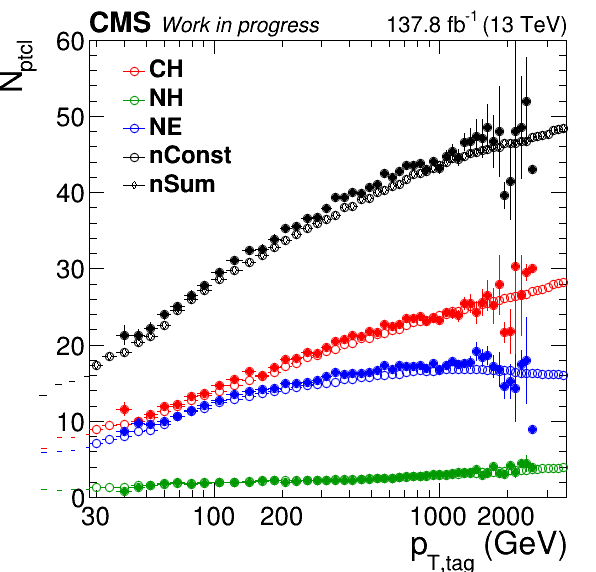

In [19]:
%jsroot off
# Function for tdrStyle axes and limit setting----------------------
def tdrAxes(hist, y_low, y_up):
    hist.GetYaxis().SetRangeUser(y_low, y_up)
    hist.GetXaxis().SetRangeUser(30, 3500)
    hist.GetXaxis().SetMoreLogLabels()
    hist.GetXaxis().SetNoExponent()

style = ROOT.setTDRStyle()
# Plot --------------------------------------------------------------
hist = ROOT.TH1D("h1", "h1 title;p_{T,tag} (GeV);N_{ptcl}", cnt, bins)

ROOT.extraText = "Work in progress"
ROOT.lumi_13TeV = "137.8 fb^{-1}"

canv = ROOT.tdrCanvas("canvas", hist, 4, 0, ROOT.kSquare)

ROOT.tdrDraw(ChHads.GetValue(), "PL", ROOT.kOpenCircle, ROOT.kRed)
ROOT.tdrDraw(ChHads_DT.GetValue(),"PL", ROOT.kFullCircle, ROOT.kRed)
             
# ROOT.tdrDraw(Muons.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kMagenta+1)
# ROOT.tdrDraw(Muons_DT.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kMagenta+1)

ROOT.tdrDraw(Photons.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kBlue)
ROOT.tdrDraw(Photons_DT.GetValue(),"PL", ROOT.kFullCircle, ROOT.kBlue)

ROOT.tdrDraw(NeuHads.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kGreen+2)
ROOT.tdrDraw(NeuHads_DT.GetValue(),"PL", ROOT.kFullCircle, ROOT.kGreen+2)

ROOT.tdrDraw(nConst.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kBlack)
ROOT.tdrDraw(nConst_DT.GetValue(),"PL", ROOT.kFullCircle, ROOT.kBlack)

ROOT.tdrDraw(nSum.GetValue(),"PL", ROOT.kOpenDiamond, ROOT.kBlack)
ROOT.tdrDraw(nSum_DT.GetValue(),"PL", ROOT.kFullDiamond, ROOT.kBlack)


# # ROOT.tdrDraw(ChG.GetValue(),"PL", ROOT.kOpenStar, ROOT.kBlack)
# # ChG.GetValue().GetXaxis().SetRangeUser(50, 3500)
# # ROOT.tdrDraw(ChQ.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kRed)
# # ChQ.GetValue().GetXaxis().SetRangeUser(50, 3500)

tdrAxes(hist, 0, 60)
leg = ROOT.tdrLeg(0.2,0.65,0.4,0.9)
leg.AddEntry(ChHads.GetValue(), "CH", "pl")
# leg.AddEntry(Muons.GetValue(), "ME", "pl")
leg.AddEntry(NeuHads.GetValue(), "NH", "pl")
leg.AddEntry(Photons.GetValue(), "NE", "pl")
leg.AddEntry(nConst.GetValue(), "nConst", "pl")
leg.AddEntry(nSum.GetValue(), "nSum", "pl")

# leg.AddEntry(ChG.GetValue(), "G", "pl")
# leg.AddEntry(ChQ.GetValue(), "Q", "pl")
# leg.AddEntry(ChHads.GetValue(), "inclusive", "pl")


ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature

# late = ROOT.TLatex()
# late.SetNDC()
# late.DrawLatex(.2, .2, "|#eta| < 1.3; #DeltaR < 0.2; p_{T} > 15 GeV")

canv.SetLogx()
canv.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


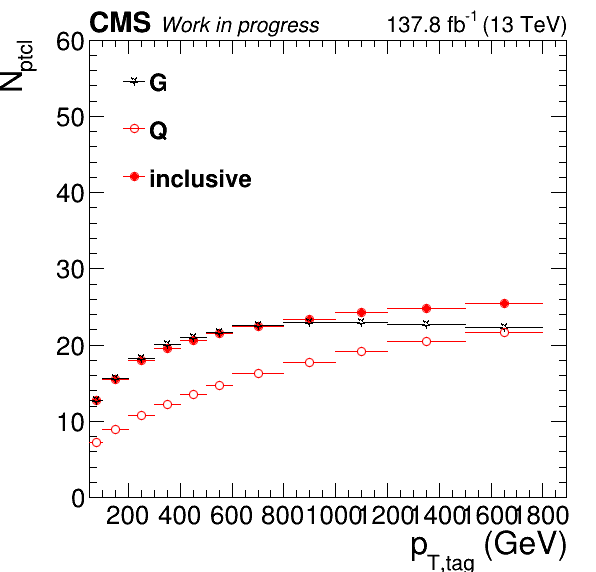

In [27]:
# Function for tdrStyle axes and limit setting----------------------
def tdrAxes(hist, y_low, y_up):
    hist.GetYaxis().SetRangeUser(y_low, y_up)
    hist.GetXaxis().SetRangeUser(50, 1800)
    hist.GetXaxis().SetMoreLogLabels()
    hist.GetXaxis().SetNoExponent()

hist = ROOT.TH1D("h1", "h1 title;p_{T,tag} (GeV);N_{ptcl}", cnt, bins)

canv = ROOT.tdrCanvas("canvas", hist, 4, 0, ROOT.kSquare)

ROOT.tdrDraw(ChHads_ATL.GetValue(),"PL", ROOT.kFullCircle, ROOT.kRed)


ROOT.tdrDraw(ChG.GetValue(),"PL", ROOT.kOpenStar, ROOT.kBlack)
ChG.GetValue().GetXaxis().SetRangeUser(50, 1800)
ROOT.tdrDraw(ChQ.GetValue(),"PL", ROOT.kOpenCircle, ROOT.kRed)
ChQ.GetValue().GetXaxis().SetRangeUser(50, 1800)

tdrAxes(hist, 0, 60)
leg = ROOT.tdrLeg(0.2,0.65,0.4,0.9)

leg.AddEntry(ChG.GetValue(), "G", "pl")
leg.AddEntry(ChQ.GetValue(), "Q", "pl")
leg.AddEntry(ChHads_ATL.GetValue(), "inclusive", "pl")


ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature



# canv.SetLogx()
canv.Draw()